<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Natural Language Processing</h1>
<h1>Text Classification</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import gzip
from collections import Counter
from pprint import pprint

import string

import pandas as pd
import numpy as np
np.random.seed(123456)

import matplotlib
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm
tqdm.pandas()

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import torchview
from torchview import draw_graph

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
stopwords = set(stopwords.words('english'))

import sklearn
from sklearn.manifold import TSNE

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: cbc605876514759eff1e35662aa7a98f5b6e3539

torch     : 2.6.0
re        : 2.2.1
watermark : 2.4.3
torchview : 0.2.6
sklearn   : 1.6.1
matplotlib: 3.8.0
numpy     : 1.26.4
pandas    : 2.2.3
nltk      : 3.8.1



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Word Embeddings

We start by loading pre-computed Word Embeddings

In [4]:
word_dict = {}
word_list = []
embeddings = np.zeros((400_000, 50), dtype='float32')

count = 0

with gzip.open('data/glove.6B.50d.txt.gz', 'rt') as fp:
    for line in tqdm(fp, total=400_000):
        fields = line.split()
        word = fields[0]
        
        word_list.append(word)
        word_dict[word] = count
        
        embeddings[count] = np.asarray(fields[1:], dtype='float32') 
        count += 1

  0%|          | 0/400000 [00:00<?, ?it/s]

Text(0, 0.5, 'Dimensions')

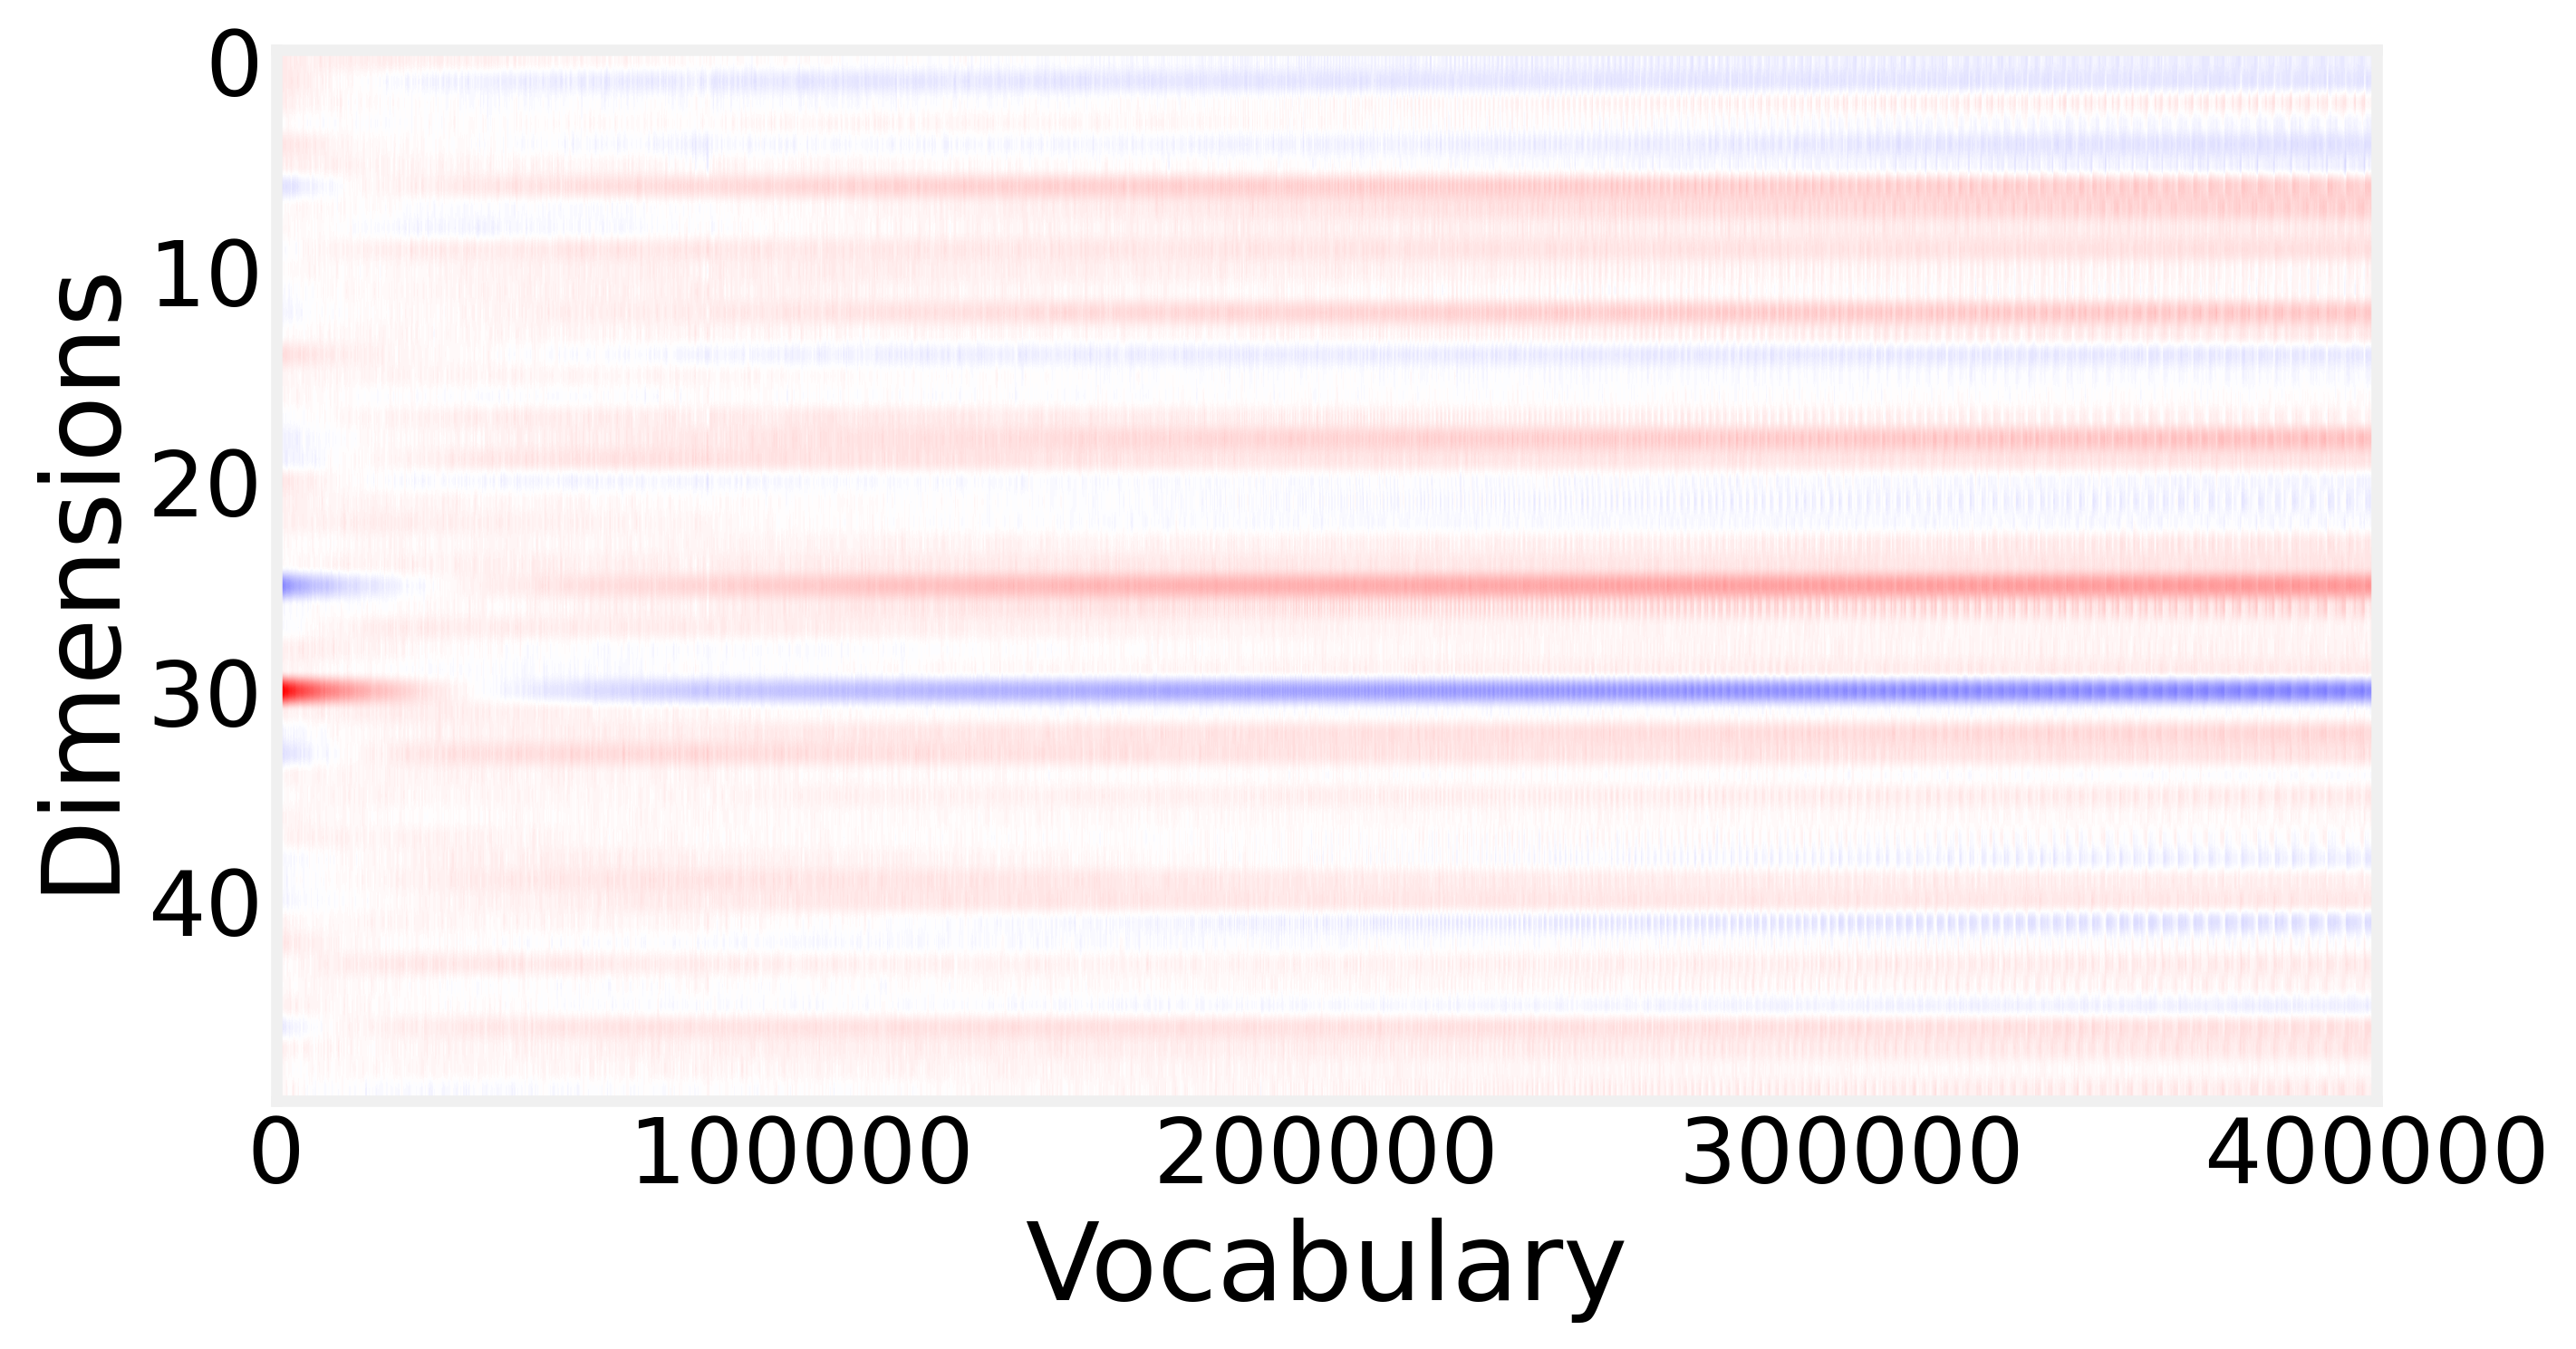

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.imshow(embeddings.T, aspect=4000, cmap=plt.cm.seismic)
ax.grid(None)
ax.set_xticks([0, 100_000, 200_000, 300_000, 400_000])
ax.set_xlabel("Vocabulary")
ax.set_ylabel("Dimensions")

A 2D projection makes it clear that semantics is also encoded in the representation

In [6]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500 # Plot only 500 words
low_dim_embs = tsne.fit_transform(np.array(embeddings)[:plot_only, :])

In [7]:
labels = [word_list[i] for i in range(plot_only)]

In [8]:
plt.figure(figsize=(18, 18))

for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                fontsize=12)


# IMDB Dataset

The IMDB dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). We load it directly from the data directory in the repository

In [9]:
data = pd.read_csv('data/IMDB Dataset.csv')

We transform the sentiment label into a numeric value

In [10]:
data['label'] = data['sentiment'].progress_apply(lambda x: 1 if x=='positive' else 0)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [11]:
def keep_words(text):
    if len(set(text) & set(string.ascii_letters)) != len(set(text)):
        return None
    
    return text

def preprocess_pipeline(text):
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(text)
    no_stopwords = [token for token in tokens if token not in stopwords]
    lemmas = [lemmatizer.lemmatize(t) for t in no_stopwords]
    words = [word for word in lemmas if keep_words(word) is not None]

    return ' '.join(words)

In [12]:
data['processed'] = data['review'].progress_apply(preprocess_pipeline)
data.head()

  0%|          | 0/50000 [00:00<?, ?it/s]

,review,sentiment,label,processed
0,One of the other reviewers has mentioned that ...,positive,1,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,A wonderful little production br br The filmin...
2,I thought this was a wonderful way to spend ti...,positive,1,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,Petter Mattei Love Time Money visually stunnin...


Extract all the tokens

In [13]:
reviews = data.processed.values
words = ' '.join(reviews)
words = words.split()

Build vocabulary

In [14]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
word_dict = dict(zip(vocab, range(1, len(vocab)+1)))
word_dict['<PAD>'] = 0

word_list = ['<PAD>']
word_list.extend(vocab)

vocab_size = len(vocab)

Tokenize reviews

In [15]:
reviews_enc = [[word_dict[word] for word in review.split()] for review in tqdm(reviews)]

  0%|          | 0/50000 [00:00<?, ?it/s]

Make sure all the reviews have the same length. We truncate reviews that are too long and pad the ones that are too short

In [16]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

max_words = 500
features = pad_features(reviews_enc, pad_id=word_dict['<PAD>'], seq_length=max_words)

Now we have a matrix where each row corresponds to a unique review and each column to each of the words

In [17]:
features.shape

(50000, 500)

Train, test and valication splits

In [18]:
train_size = .7     # 70% used for training
val_size = .5       # 50% of test data set used for validation

In [19]:
labels = data.label.to_numpy()

# Training dataset
split_id = int(len(features) * train_size)
X_train, X_remain = features[:split_id], features[split_id:]
y_train, y_remain = labels[:split_id], labels[split_id:]

# Testing and Validation
split_val_id = int(len(X_remain) * val_size)
X_validation, X_test = X_remain[:split_val_id], X_remain[split_val_id:]
y_validation, y_test = y_remain[:split_val_id], y_remain[split_val_id:]

In [20]:
print('Shape of training data:', X_train.shape)
print('Shape of test data:', X_test.shape)
print('Shape of validation data:', X_validation.shape)

Shape of training data: (35000, 500)
Shape of test data: (7500, 500)
Shape of validation data: (7500, 500)


# PyTorch

## Tensor datasets

In [21]:
trainset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
validset = TensorDataset(torch.from_numpy(X_validation), torch.from_numpy(y_validation))
testset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

## Data Loaders

In [22]:
batch_size = 128
hidden_size = 32
output_size = 1

In [23]:
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

Finally, we are ready to define our models

# Feed Forward Model

We'll start by training a simple FF model without any fancyness. 

Our model will have an embedding layer to turn our numerical ids into vectors, a hidden dense layer of 32 neurons and ReLu activation followed by an output layer with just one neuron and a sigmoid activation

In [24]:
class FFNet(nn.Module):
    def __init__(self):
        super(FFNet, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, 50)
        self.flatten = nn.Flatten(1, -1)
        self.linear1 = nn.Linear(50*max_words, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        emb = self.word_embeddings(x)
        flat = self.flatten(emb)
        line1 = self.linear1(flat)
        relu = self.relu(line1)
        line2 = self.linear2(relu)
        output = self.sigmoid(line2)

        return output

In [25]:
FF_model = FFNet()

Now we generate and load the embedding matrix

In [26]:
embedding_matrix = np.zeros((vocab_size, 50), dtype='float32')

count = 0

with gzip.open('data/glove.6B.50d.txt.gz', 'rt') as fp:
    for line in tqdm(fp, total=400_000):
        fields = line.split()
        word = fields[0]
        
        if word in word_dict:
            pos = word_dict[word]
            
            if pos < vocab_size:
                count += 1
                pos = word_dict[word]
                embedding_matrix[pos] = np.asarray(fields[1:], dtype='float32')        

  0%|          | 0/400000 [00:00<?, ?it/s]

In [27]:
FF_model.word_embeddings.weight.data.copy_(torch.from_numpy(embedding_matrix))

# Don't update the embeddings
FF_model.word_embeddings.weight.requires_grad=False

In [28]:
print(FF_model)

FFNet(
  (word_embeddings): Embedding(114608, 50)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=25000, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [29]:
# define training device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


Hyperparameters

In [30]:
vocab_size = len(word_list)
output_size = 1
embedding_size = 50
hidden_size = 32

Then, we define some training config for our model. Since we have *binary classification* task, we will use **Binary Cross Entropy Loss (BCELoss)** as our loss function. And we will use **Adam** as optimizer as it shown in many references that it could find converge point quickly. Based on 

In [31]:
# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(FF_model.parameters(), lr=lr)
grad_clip = 5
epochs = 8
print_every = 1
es_limit = 5

**This is our main part!**
<br>
So, here we define training and validation loop. We will use only 5 epochs and see if we need more or less epochs to obtain good performance. We log our loss and accuracy for each epochs, so we can plot them later to see how the performances. Inspired by https://github.com/LukeDitria/pytorch_tutorials

In [32]:
def train_model(model, epochs, optim):
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epochs': epochs
    }

    # train loop
    model = model.to(device)

    epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

    # early stop trigger
    es_trigger = 0
    val_loss_min = torch.inf

    for e in epochloop:

        #################
        # training mode #
        #################

        model.train()

        train_loss = 0
        train_acc = 0

        for id, (feature, target) in enumerate(trainloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # reset optimizer
            optim.zero_grad()

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            train_loss += loss.item()
            loss.backward()

            # clip grad
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # update optimizer
            optim.step()

            # free some memory
            del feature, target, predicted

        history['train_loss'].append(train_loss / len(trainloader))
        history['train_acc'].append(train_acc / len(trainloader))

        ####################
        # validation model #
        ####################

        model.eval()

        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for id, (feature, target) in enumerate(valloader):
                # add epoch meta info
                epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')

                # move to device
                feature, target = feature.to(device), target.to(device)

                # forward pass
                out = model(feature)

                # acc
                predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                val_acc += acc.item()

                # loss
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

                # free some memory
                del feature, target, predicted

            history['val_loss'].append(val_loss / len(valloader))
            history['val_acc'].append(val_acc / len(valloader))

        # reset model mode
        model.train()

        # add epoch meta info
        epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

        # print epoch
        if (e+1) % print_every == 0:
            epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
            epochloop.update()
            
    return history

In [33]:
def plot_history(history):    
    fig, ax_lst = plt.subplots(1, 2, sharex=True, sharey=True)
    
    epochs = range(history['epochs'])
    
    ax_lst[0].plot(epochs, history['train_loss'], label='Training')
    ax_lst[0].plot(epochs, history['val_loss'], label='Testing')
    ax_lst[0].set_ylabel('Loss')
    ax_lst[0].set_xlabel('Epoch')
    ax_lst[0].set_xticks(epochs)
    
    ax_lst[1].plot(epochs, history['train_acc'], label='Training')
    ax_lst[1].plot(epochs, history['val_acc'], label='Testing')
    ax_lst[1].set_ylabel('Accuracy')
    ax_lst[1].set_xlabel('Epoch')
    ax_lst[1].set_xticks(epochs)

    ax_lst[1].legend()
    
    fig.tight_layout()

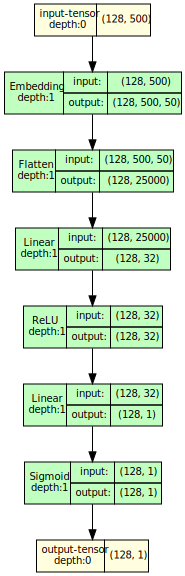

In [34]:
draw_graph(FF_model, input_data=torch.as_tensor(X_test[:128])).visual_graph

In [35]:
history = train_model(FF_model, epochs, optim)

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.566 Train Acc: 0.707 | Val Loss: 0.537 Val Acc: 0.730
Epoch 2/8 | Train Loss: 0.457 Train Acc: 0.785 | Val Loss: 0.573 Val Acc: 0.720
Epoch 3/8 | Train Loss: 0.393 Train Acc: 0.819 | Val Loss: 0.584 Val Acc: 0.733
Epoch 4/8 | Train Loss: 0.332 Train Acc: 0.852 | Val Loss: 0.637 Val Acc: 0.727
Epoch 5/8 | Train Loss: 0.269 Train Acc: 0.886 | Val Loss: 0.690 Val Acc: 0.728
Epoch 6/8 | Train Loss: 0.207 Train Acc: 0.918 | Val Loss: 0.833 Val Acc: 0.725
Epoch 7/8 | Train Loss: 0.150 Train Acc: 0.947 | Val Loss: 0.936 Val Acc: 0.721
Epoch 8/8 | Train Loss: 0.104 Train Acc: 0.968 | Val Loss: 1.079 Val Acc: 0.717


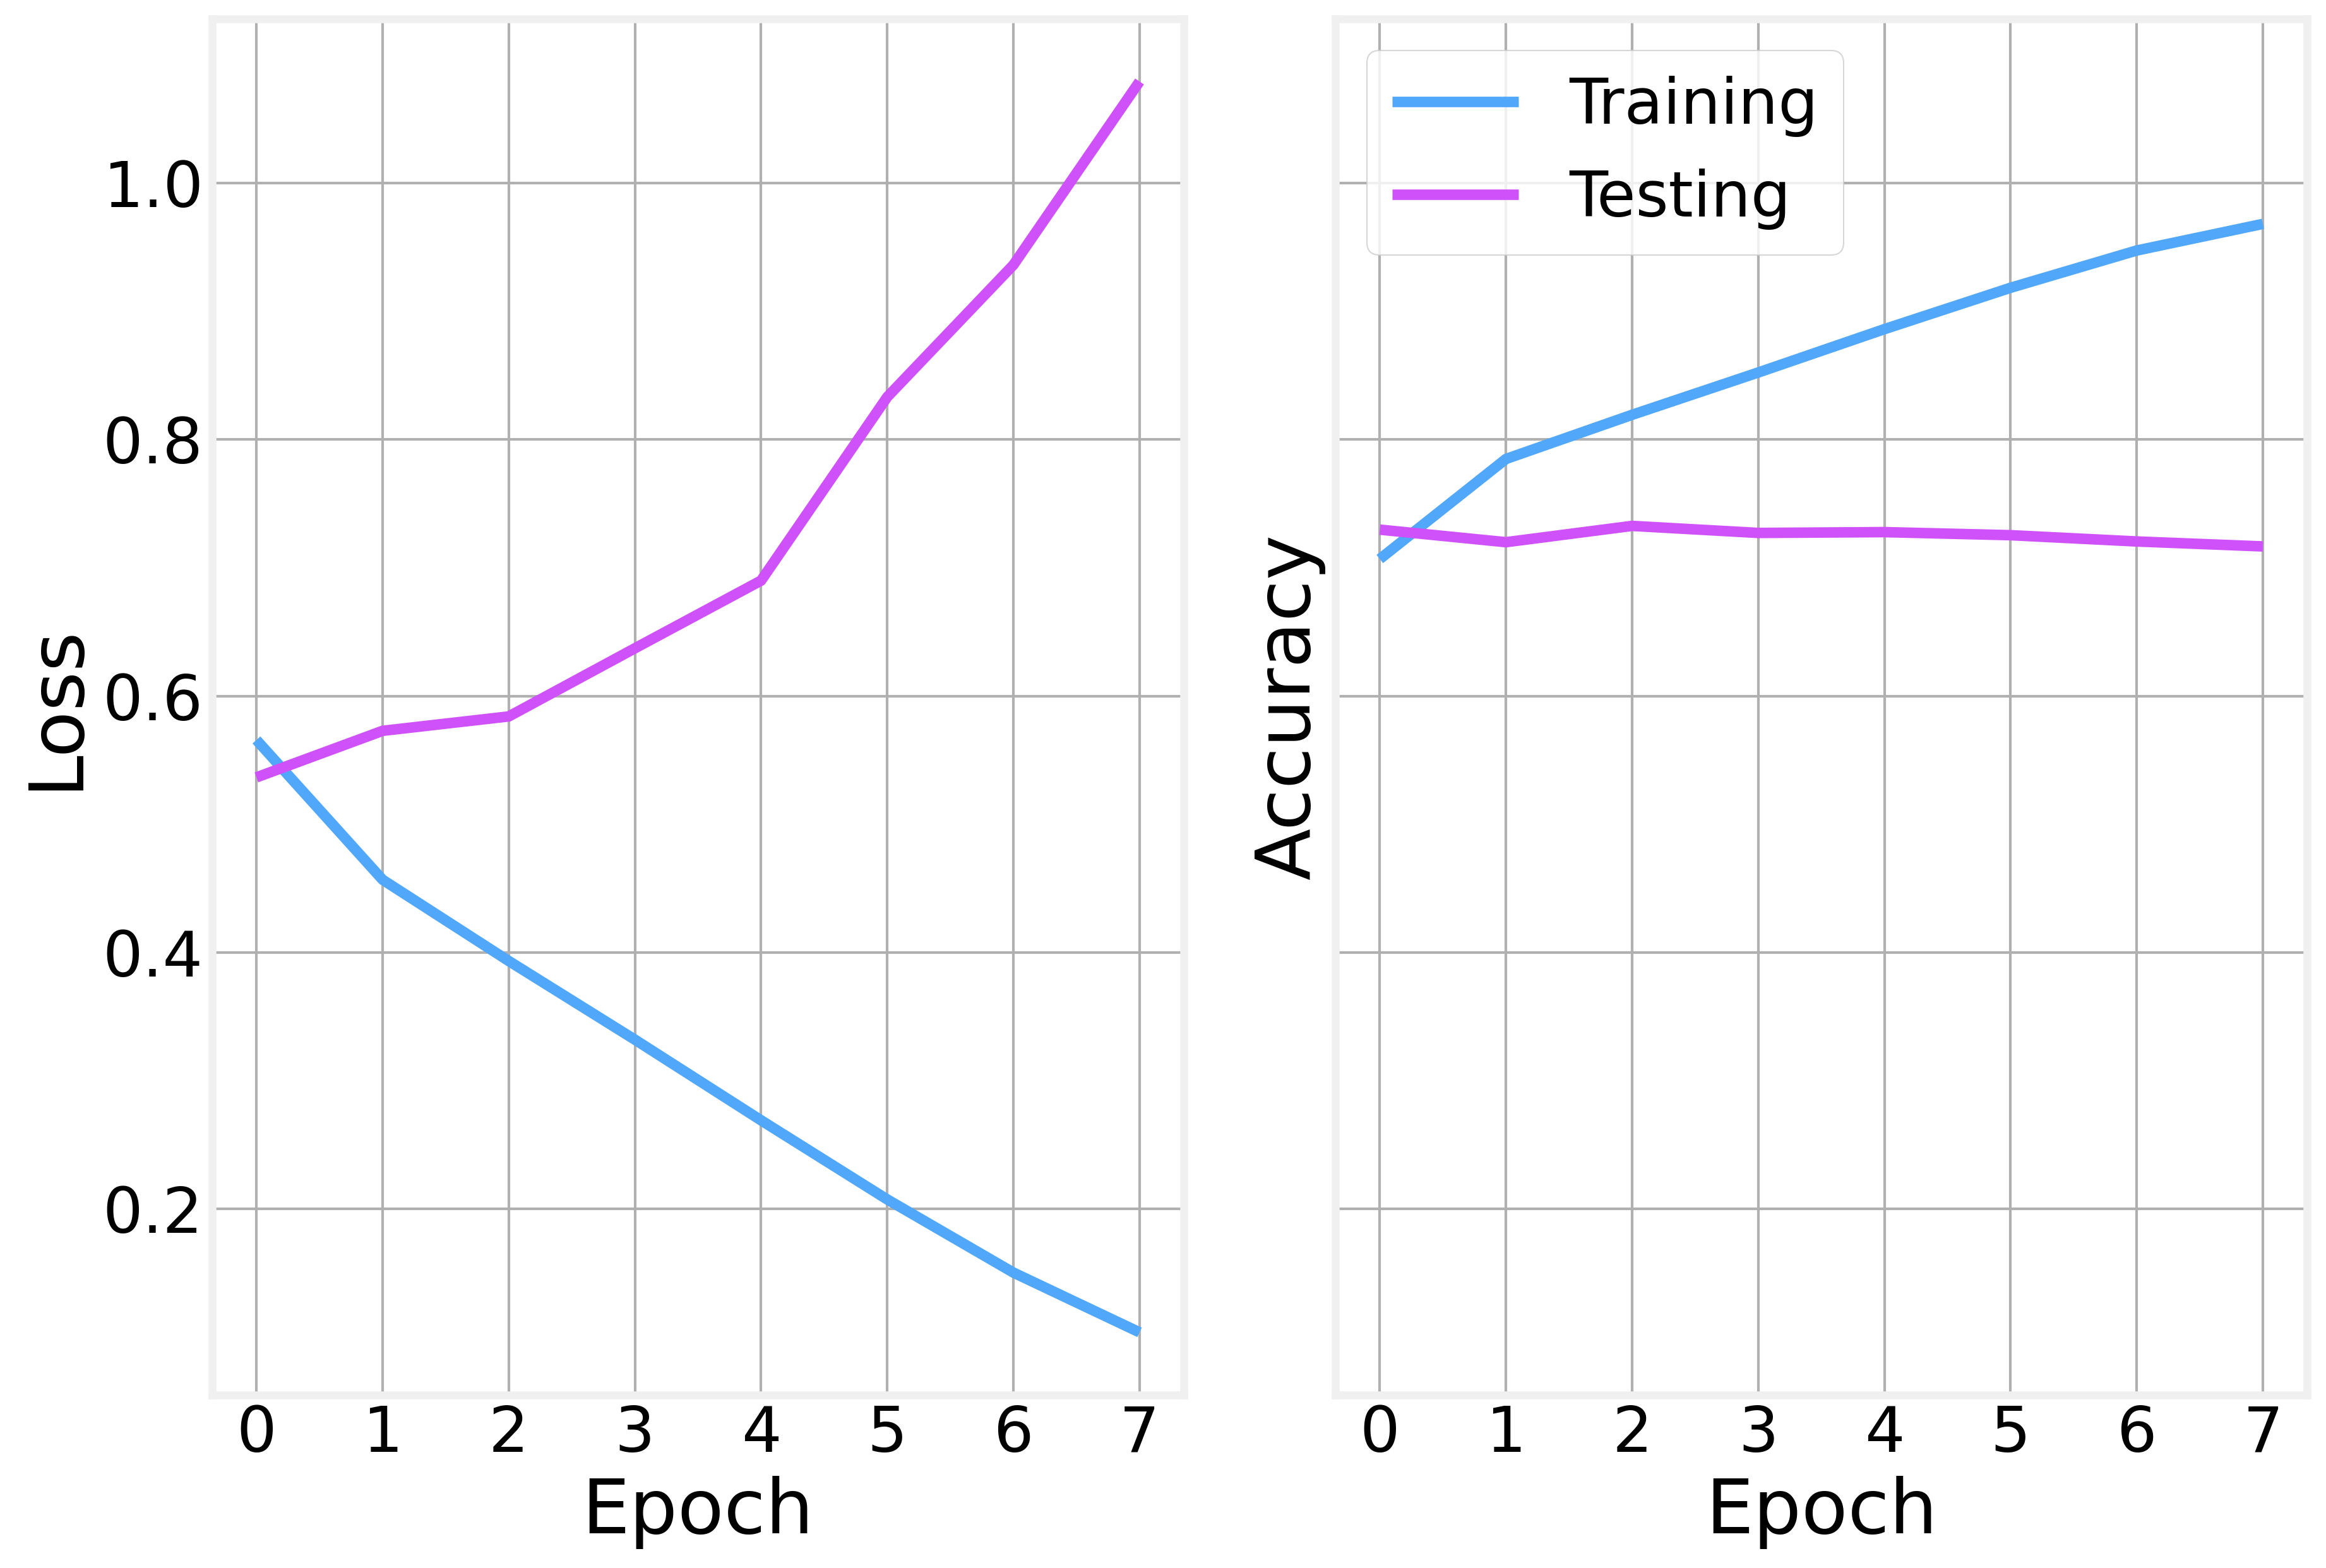

In [36]:
plot_history(history)

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>